# How Bi-Persistence Clustering Works

`biperscan` adapts HDBSCAN\* to extract clusters from bi-filtrations over a
distance scale and an centrality scale (other lens-dimensions are untested but
might work as well). This type of clustering is particularly useful for
detecting (lower-density) branches in a datasets. Such branches are difficult to
detect with clustering algorithms because they are connected to a central core
through short distances. In other words, there is no gap or low-density region
separating the branches and the central core. Hierarchical and density-based
clustering algorithms rely on such a gap to detect clusters, and therefore
struggle to detect branches.

A bi-filtration effectively introduces a gap between the branches by filtering
out central points with a varying centrality threshold, allowing the branches to
be detected as separate connected components (i.e., clusters).

While `biperscan` is implemented to be fast, it does not scale nicely with data
size. For practical applications, we instead recommend
[pyflasc](https://github.com/vda-lab/pyflasc): our more efficient branch &
cluster detection algorithm. The main difference between `biperscan` and
`pyflasc` is that `pyflasc` first extracts HDBSCAN\* clusters and then extracts
branches within the clusters, rather than trying to detect both at the same
time. This results in two fast filtrations, instead of one expensive
bi-filtration.

In [1]:
%load_ext autoreload
%autoreload 2

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from hdbscan import HDBSCAN
from biperscan import BPSCAN

from lib.drawing import plot_five_points_all, plot_five_points_minpres
from lib.plotting import *

palette = configure_matplotlib()

## The data

This example uses a noisy, 2D dataset from [pyflasc's
examples](https://vda-lab.github.io/pyflasc/How_FLASC_works.html), originally
adapted from [HDBSCAN\*'s soft clustering
tutorial](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html).
One of the clusters has a Y-shape and contains three branches. These (kind of)
branches are not detected by HDBSCAN and other distance-based clustering
algorithms
([demo](https://vda-lab.github.io/pyflasc/Comparison_algorithms.html)). BPSCAN
is able to detect the branches as distinct clusters, but struggles to generate a
good labelling and is quite sensitive to the input parameters:

In [176]:
X = np.load("data/flared/flared_clusterable_data.npy")
c = BPSCAN(
  min_samples=20, 
  min_cluster_size=80,
  distance_fraction=0.03
).fit(X)

In [167]:
scatter_kwargs = dict(s=1, alpha=0.5, linewidths=0, edgecolor="none")
color_kwargs = dict(
    cmap=ListedColormap(["silver"] + [f"C{i}" for i in range(10)]), vmin=-1, vmax=9
)

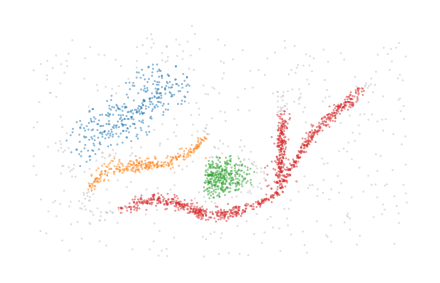

In [168]:
sized_fig(0.5)
plt.scatter(
    *X.T,
    c=HDBSCAN(min_samples=25, min_cluster_size=80).fit_predict(X),
    **scatter_kwargs,
    **color_kwargs
)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig("images/flareable_hdbscan_clusters.pdf", pad_inches=0)
plt.show()

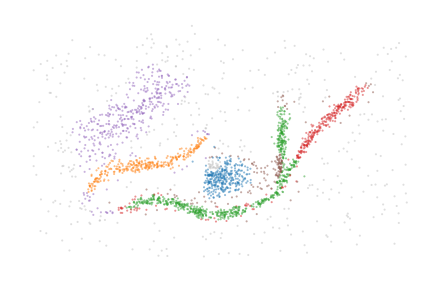

In [170]:
sized_fig(0.5)
plt.scatter(
    *X.T,
    c=c.labels_at_depth(1),
    **scatter_kwargs,
    **color_kwargs
)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig("images/flareable_bpscan_clusters.pdf", pad_inches=0)
plt.show()

## The BPSCAN algorithm

The remainder of this notebook explains how the BPSCAN algorithm works and is separated into sections: 

- [The centrality lens](#the-centrality-lens)
- [The minimal presentation](#the-minimal-presentation)
- [Extracting merges](#extracting-merges)
- [Constructing a merge hierarchy](#constructing-a-merge-hierarchy)
- [Labelling clusters](#labelling-clusters)

### The centrality lens

A centrality lens is used to detect branches in the bi-filtration. Effectively,
the process continually looks for clusters while increasing a centrality
threshold that allows more central points to enter the filtration. Initially, at
low thresholds, all central points are excluded, which separates the branches
from each other so they can be detected as clusters. As the centrality threshold
increases, the distance between the branches shrinks until they are detected as
a single cluster.

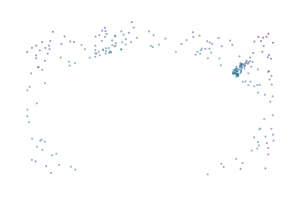

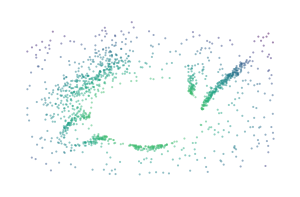

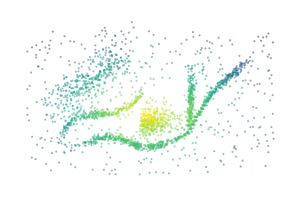

In [151]:
for i, threshold in enumerate([0.4, 0.7, 1.0]):
    sized_fig(0.33)
    mask = c.lens_values_ < threshold
    plt.scatter(
        *X[mask].T,
        c=c.lens_values_[mask],
        cmap="viridis",
        vmin=0,
        vmax=1,
        **scatter_kwargs
    )
    plt.subplots_adjust(0, 0, 1, 1)
    plt.axis("off")
    plt.savefig(f"images/flareable_centrality_threshold_{i}.pdf", pad_inches=0)
plt.show()

Biperscan supports three centrality lenses:

- negative_distance_to_mean
- negative_distance_to_median
- negative_eccentricity

Only the `negative_eccentricity` works with precomputed distances.

### The minimal presentation

Where hierarchical clustering extract clusters from a *minimum spanning tree*,
multi-parameter persistence works with *minimal presentations*. The idea is the
same: minimum presentations contain all topology changing edges in a
bi-filtration (we only consider 0-dimensional persistence, so edges are the
highest dimensional simplex we use). Because the bi-filtration considers two
parameters, minimal presentations typically contain more than N-1 edges.


As example, consider five points that lie on the corners and center of a
rectangle. A bi-filtration needs to consider all edges between the points, but
only a few of those edges are the first to connected points together. These
latter edges form the minimal presentation!

We made a small but influential change to the algorithm that constructs the
*minimal presentation*: points are connected to their lowest lens-grade
accessible ancestor rather than their direct parent. The default algorithm
already does this to some degree. We added a step to ensure it always happens.

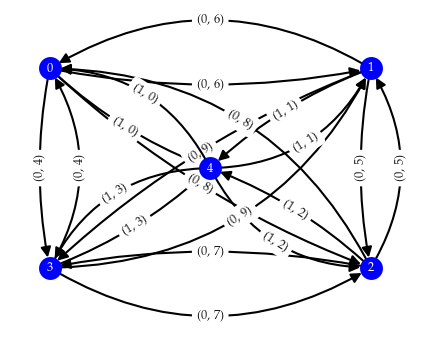

In [148]:
sized_fig(0.5, aspect=0.75)
plot_five_points_all()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/five_points_all.pdf", pad_inches=0)
plt.show()

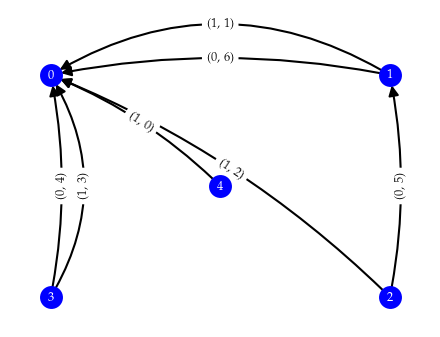

In [150]:
sized_fig(0.5, aspect=0.75)
plot_five_points_minpres()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/five_points_minpres.pdf", pad_inches=0)
plt.show()

The minimal presentation for the noisy data shows why the noise points are
tricky. The repeated edges, which occur between ancestors connected to multiple
other points, lie between the most eccentric (noise) points.

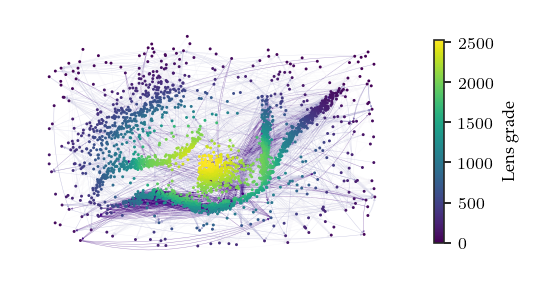

In [133]:
minpres = c.minimal_presentation_

sized_fig(0.5)
minpres.plot_network(
    layout={i: (c[0], c[1]) for i, c in enumerate(X)},
    labels=False,
    node_kws=dict(node_size=2, edgecolors="none", linewidths=0),
    line_kws=dict(width=0.2, arrowsize=2, alpha=0.5, edge_vmin=0, edge_vmax=100000),
)
plt.subplots_adjust(0, 0, 1.2, 1)
plt.savefig('images/flareable_minimal_presentation_network.png', pad_inches=0)
plt.show()

Another way to view the minimal presentation is through the range of
lens--distance grades data points are *alive*. The edges in the minimal
presentation represent when the child *dies* into the parent. So, we can draw a
curve for each point, indicating at which grades it merges with a parent. The
area under these curves, represents the persistence of the data points.
Meaningfully combining lens and distance values is tricky, as they do not
necessarily relate to each other.

Visually, the lens--distance plot is not very informative, but it does indicate
that most points merge at very low distance grades.

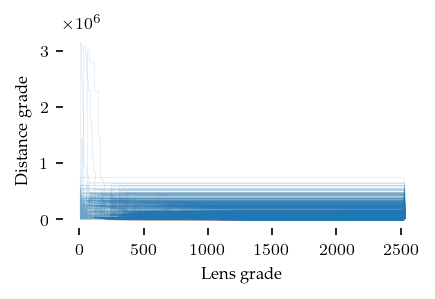

In [117]:
sized_fig(0.5)
minpres.plot_persistence_areas(
    line_kws=dict(alpha=0.1, linestyle="-", linewidths=0.5)
)
plt.subplots_adjust(0.13, 0.23, 1, 1)
plt.savefig("images/flareable_persistence_areas.png", pad_inches=0)
plt.show()

### Extracting merges

The next step for adapting HDBSCAN would be to convert the minimal presentation
into a linkage hierarchy, which would then be simplified using a minimum cluster
size threshold to produce a condensed cluster tree. 

It turns out that extracting merges between clusters with a minimum size is
easier when done on the minimal presentation directly, rather than a bi-graded
linkage hierarchy. We do provide code that computes such linkage hierarchies,
but do not use the hierarchy in the BPSCAN algorithm. Bi-graded linkage
hierarchies are considerably larger than the minimal presentation they originate
from because they enumerate all data-point combinations that exist throughout
the bi-filtration, making them more expensive to create and work with. Minimal
presentations encode many of these combinations implicitly.

To explain how we extract merges, we first need to explain how minimal
presentations are represented. Minimal presentations are constructed in the form
of a (boundary) matrix. In our case, rows represent data points (ordered with
increasing lens grade) and columns represent edges (ordered with
lexicographically increasing bi-grades). The minimal presentation for the five
points on a rectangle is shown below. The 1s indicate which points are connected
in each column:

```text
  0, 4  0, 5  0, 6  1, 0  1, 1  1, 2  1, 3 
  0<-3  1<-2  0<-1  0<-4  0<-1  0<-2  0<-3 
0   1           1     1     1     1     1  
1         1     1           1              
2         1                       1        
3   1                                   1  
4                     1                     	
```

To extract the merges, we look for two columns with the same child point. These
columns represent two edges connected to the one point: one to each (potential)
cluster connected through the child point. There are three column pairs with
this pattern in the example minimal presentation. One connecting different
parent points and two connecting to the same parent points. Finding these column
pairs is easy, by traversing the minimal presentation from left to right and
storing the previous column seen for each child point.  Lets focus on the one
connecting different parent points for now:

```text
  0, 4  0, 5  0, 6  1, 0  1, 1  1, 2  1, 3 
  0<-3  1<-2  0<-1  0<-4  0<-1  0<-2  0<-3 
0   1           1     1     1     1     1  
1         1     1           1              
2         1 <-------------------> 1        
3   1                                   1  
4                     1                     	
```

To check whether these edges merge clusters at the given minimum cluster size,
we need to figure out if both parents connect to enough other points before
connecting to each other. For this purpose we interpret the matrix as an
undirected graph, facilitating traversal. In this case, we consider all edges to
the left of bi-grade $(1, 5)$, the grade induced by the selected columns. Then,
we perform a set-symmetric-difference-like iteration that traverses from the
parent with the lowest distance edge and collects all points connected to it
within that distance. The iteration stops when one side connects to a point
already contained by the other side or when both sides do not have any edges
remaining. The child point is excluded from the traversal, as it would be found
by both sides immediately, thereby stopping the iteration. Merges are stored
throughout the iteration when both sides have reached the minimum cluster size.

In the case were the parent match, we traverse from the parent and child points
instead. Because this pattern tends to occur multiple times between the same
points, we also use the left-most column's distance grade as an upper distance
limit, avoiding re-checking the same edges multiple times. In the example shown
below, a merge would be found between points (1, 2) and (0, 3, 4).

```text
  0, 4  0, 5  0, 6  1, 0  1, 1  1, 2  1, 3 
  0<-3  1<-2  0<-1  0<-4  0<-1  0<-2  0<-3 
0   1           1     1     1     1     1  
1         1     1 <-------> 1              
2         1                       1        
3   1                                   1  
4                     1                     	
```

On noisy data sets, it can be beneficial to set an upper distance bound for the
traversal to exclude noisy points. In addition, the procedure typically finds
multiple merges between the same root points at a particular lens grade. These
merges differ in their distance grade, and show how points enter the clusters
over the distance. We only use the largest distance merge per lens grade and
root point pair. Below are the selected merges found for the noisy data example:

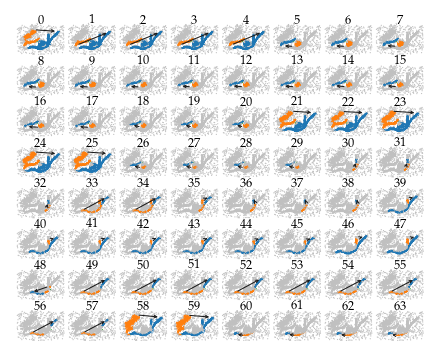

In [106]:
sized_fig(0.5, aspect=0.8)
merges = c.merge_hierarchy_
merges.plot_merges(*X.T, s=0.33, title_y=0.6, arrowsize=3, linewidth=0.5)
plt.subplots_adjust(0, 0, 1, 0.975, wspace=0)
plt.savefig("images/flareable_merges.png", pad_inches=0)
plt.show()

Clearly, all clusters and branches are detected by at least one merge in this
example, indicating the bi-filtration is able to detect both patterns. However,
extracting a cluster labelling from these merges is still tricky, as there
appear to be several (near) duplicates for each merge.

### Constructing a merge hierarchy

In an effort to detect which merges are (near) duplicates, we construct a
hierarchy. Merges are connected if they have the same parent root point. If the
higher-value child root point is contained in the lower-value child root point's
cluster, the edge is labelled as `same_parent` indicating the merges are (near)
duplicates. Otherwise the edge is labelled as `into_parent`, indicating the
parent cluster contains multiple different child clusters. The same procedure is
applied to merges with the same child root point. This typically results in a graph with
few connected components. 

To ensure the graph is connected, we compute a hamming loss between the merges
in the components, where the child and parent side membership is interpreted as
a prediction label. The shortest connections between the components are
repeatedly added until all components are connected:

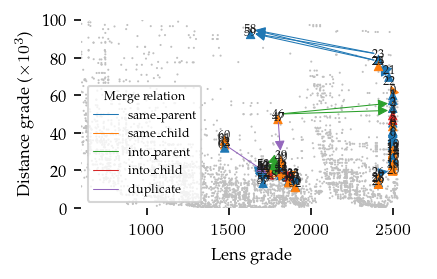

In [109]:
sized_fig(0.5)
merges.plot_persistence_areas(line_kws=dict(width=0.5), font_kws=dict(font_size=6))
plt.subplots_adjust(0.12, 0.17, 1, 0.97)
plt.yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels([f"{int(v/1000)}" for v in plt.gca().get_yticks()])
plt.xlim(600, plt.xlim()[1])
plt.ylim(0, 100000)
plt.ylabel("Distance grade ($\\times 10^3$)")
plt.subplots_adjust(0.17, 0.23, 1, 0.97)
plt.savefig("images/flareable_merge_hierarchy.png", pad_inches=0)
plt.show()

Now, the merges connected through `same_parent`, `same_child`, or `duplicate`
edges are aggregated into a single node, while maintaining their `into_parent`
and `into_child` edges. The resulting simplified graph has a single node for all
the (near) duplicate merges and indicates whether connected nodes are part of
the parent or child side:

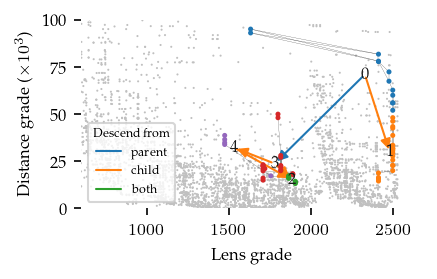

In [108]:
sized_fig(0.5)
simplified_merges = c.simplified_hierarchy_
simplified_merges.plot_persistence_areas(
    node_kws=dict(node_size=2), line_kws=dict(width=1)
)
plt.yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels([f"{int(v/1000)}" for v in plt.gca().get_yticks()])
plt.xlim(600, plt.xlim()[1])
plt.ylim(0, 100000)
plt.ylabel("Distance grade ($\\times 10^3$)")
plt.subplots_adjust(0.17, 0.23, 1, 0.97)
plt.savefig("images/flareable_simplified_hierarchy.png", pad_inches=0)
plt.show()

The main reason for this aggregation step is to reduce the number of merges and combine the (near) duplicate merges. For the noisy data, five merges remain, clearly identifying the cluster at multiple distance scales:

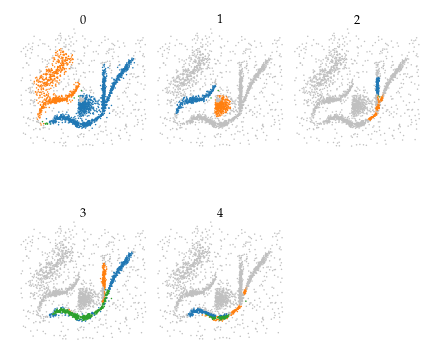

In [175]:
sized_fig(0.5, aspect=0.8)
simplified_merges.plot_merges(*X.T, s=0.5, title_y=0.9)
plt.subplots_adjust(0, 0, 1, 0.98, wspace=0, hspace=0.5)
plt.savefig("images/flareable_aggregated_merges.png", pad_inches=0)
plt.show()

The green points indicate points that are contained in both the parent and the
child side. While we avoid this possibility in individual merges, combining them
in the aggregation step can introduce overlaps.

### Labelling clusters

The final step is to convert the simplified hierarchy into cluster labels. This
is done through a depth-first traversal (ordered by node index) while keeping
track of the points already assigned a label. At each node, first its children
are processed. Then, the child-side points that are not already assigned a point
become a new group. This group is appended to the last added child-side group if
it does not contain more than the minimum cluster size. Otherwise, the new group
is accepted as a cluster on its own. The same procedure is applied to the
parent-side. 

Sometimes, the simplified hierarchy has multiple roots. In that case, a
traversal is started from all roots in decreasing node index order. Nodes that
were visited before are skipped in the traversal.

A depth-limit parameter can be used to create a coarser cluster labelling. Due
to the traversal, the labelling can appear as if multiple clusters lay on top of
each other. For example, at depth 2, the red cluster is spread around the green
cluster. Other strategies for creating a cluster labelling might avoid this
problem.

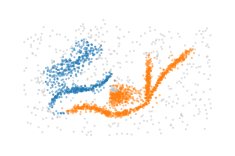

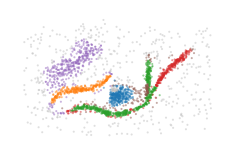

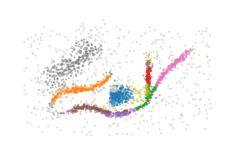

In [171]:
for i in range(3):
    sized_fig(0.25)
    print()
    plt.scatter(*X.T, c=c.labels_at_depth(i), **scatter_kwargs, **color_kwargs)
    plt.subplots_adjust(0, 0, 1, 1)
    plt.axis("off")
    plt.savefig(f"images/flareable_labels_at_depth_{i}.pdf", pad_inches=0)
plt.show()

BPSCAN also provides membership vectors, indicating the data point membership
for all simplified merges. Weighted membership is not supported yet but could be
computed, as BPSCAN tracks at which grades points enter the merges. 

The membership columns are ordered using the same depth-first traversal
strategy. As a result, using the first non-zero column as cluster label segments
the clusters quite neatly.

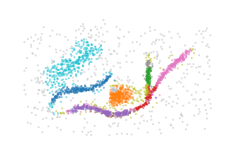

In [172]:
sized_fig(0.25)
plt.scatter(*X.T, c=c.first_nonzero_membership(), **scatter_kwargs, **color_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig(f'images/flareable_first_nonzero_membership.pdf', pad_inches=0)
plt.show()

Alternatively, the membership vectors can be used for further downstream processing. For example, they can be projected to colors using the CIELAB colorspace:

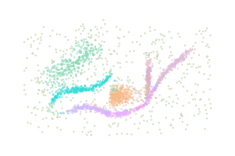

In [80]:
from sklearn.manifold import MDS
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color


def map_to_cielab(values):
    # Scale primary dimension to be within 0-100
    # Translate other dimensions to be around 0
    i = np.min(values[:, 0], axis=0)
    a = np.max(values[:, 0], axis=0)

    scaled = np.empty((values.shape[0], 3), dtype=np.float64)
    scaled[:, 0] = 80
    scaled[:, 1:] = (values - i) / (a - i) * 100
    scaled[:, 1:] -= np.mean(scaled[:, 1], axis=0)

    # Interpret as CIELAB and convert to RGB
    rgbs = []
    for i in range(len(scaled)):
        rgb = convert_color(
            LabColor(scaled[i, 0], scaled[i, 1], scaled[i, 2]), sRGBColor
        )
        rgbs += [(rgb.clamped_rgb_r, rgb.clamped_rgb_g, rgb.clamped_rgb_b)]
    return rgbs, scaled


mapping = MDS(n_components=2).fit_transform(c.membership_)
rgbs, scaled = map_to_cielab(mapping)

sized_fig(0.25)
plt.scatter(*X.T, c=rgbs, **scatter_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig('images/flareable_membership_colors.pdf', pad_inches=0)
plt.show()